# Crecimiento de una Bacteria (Dinámica Poblacional)

La dinámica poblacional busca modelar el crecimiento de una población en un lugar determinado, ya sea de una especie animal, bacteriana o vegetal. Se consideran diversos factores que afectan este crecimiento a lo largo de un período de tiempo específico.

Como ejercicio, se propone modelar el siguiente conjunto de datos y responder a las preguntas planteadas:

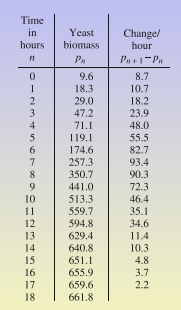

Teniendo en cuenta los datos previos de medición de la biomasa en un cultivo de levadura, ¿es posible construir un modelo matemático, estadístico o computacional que permita predecir la cantidad de biomasa después de 25 horas?

## Librerias

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp
import scipy.linalg as la

## Datos

In [28]:
hours = np.array([i for i in range(19)])
yeast_biomass = np.array([9.6, 18.3, 29.0, 47.2, 71.1, 119.1, 174.6, 257.3, 350.7,
                          441.0, 513.3, 559.7, 594.8, 629.4, 640.8, 651.1, 655.9,
                          659.6, 661.8])
Change_hour = np.array([yeast_biomass[i+1] - yeast_biomass[i] for i in range(len(hours)-1)])

### Graficos de los datos

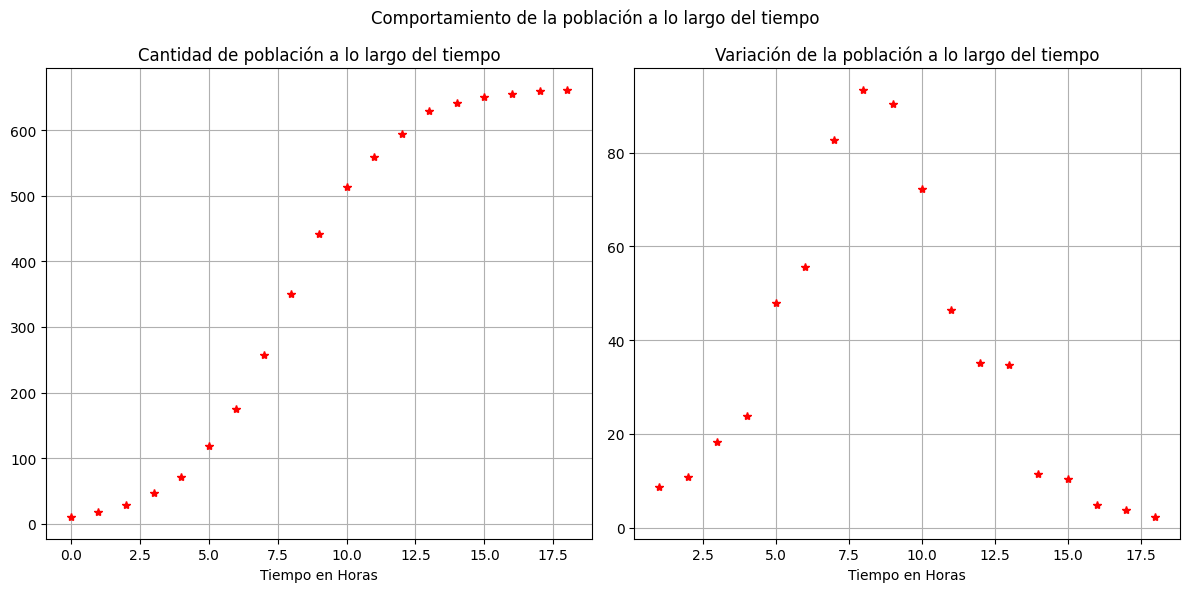

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle("Comportamiento de la población a lo largo del tiempo")


ax1.plot(hours, yeast_biomass, "r*")
ax1.set_title("Cantidad de población a lo largo del tiempo")
ax1.set_xlabel("Tiempo en Horas")
ax1.grid()

ax2.plot(hours[1:], Change_hour, "r*")
ax2.set_title("Variación de la población a lo largo del tiempo")
ax2.set_xlabel("Tiempo en Horas")
ax2.grid()

plt.tight_layout()


## Primer Modelo

Para el desarrollo del primer modelo, se trabajó exclusivamente con los datos disponibles. Para esto, se consideró el uso del método de Runge-Kutta para aproximar EDO's. No obstante, al tratarse de un sistema discreto, surgió un inconveniente: la ausencia de una función diferencial, encontrándonos en su lugar con un sistema dinámico discreto.

Por esta razón, como primera medida, para poder utilizar Runge-Kutta, se necesita una función diferencial de la forma
$\frac{dx}{dt} = F(x, t)$, donde $F(x,t)$ será el polinomio interpolador del conjunto de datos de las derivadas.

### Polinomio Interpolador

Como se mencionó previamente, para realizar el primer modelo, se necesita un polinomio interpolador para el conjunto de datos de las tasas de cambio. En este ejercicio, se decidió utilizar el spline cúbico, el cual presenta ventajas frente a otros métodos de interpolación, como la suavidad de la solución.

La suavidad de la solución se refiere a la capacidad de crear una función continua en la que tanto la primera como la segunda derivada sean también continuas, lo cual facilita el cálculo computacional. No obstante, el spline cúbico también presenta desventajas, como las condiciones de frontera, ya que, al no conocer la naturaleza de la función, determinar su comportamiento puede ser difícil y poco evidente. (Tipos de fronteras: https://www.u-cursos.cl/ingenieria/2007/2/MA33A/3/material_docente/bajar?id_material=145515)

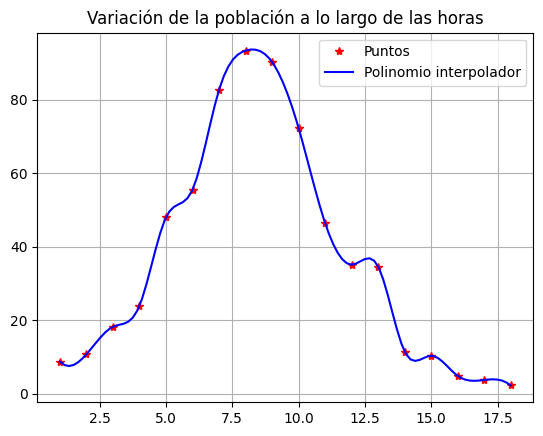

In [30]:
f = CubicSpline(hours[1:], Change_hour)

x = np.linspace(1, 18, 100)
y = f(x)

plt.plot(hours[1:], Change_hour, "r*", label="Puntos")
plt.title("Variación de la población a lo largo de las horas")
plt.plot(x, y, "b-", label="Polinomio interpolador")
plt.grid()
plt.legend()
plt.show()

En la gráfica, podemos ver el polinomio interpolador dentro del rango temporal del conjunto de datos. No obstante, surge la pregunta: ¿qué pasaría si se mueven los extremos? ¿Tiene sentido la interpretación o no?

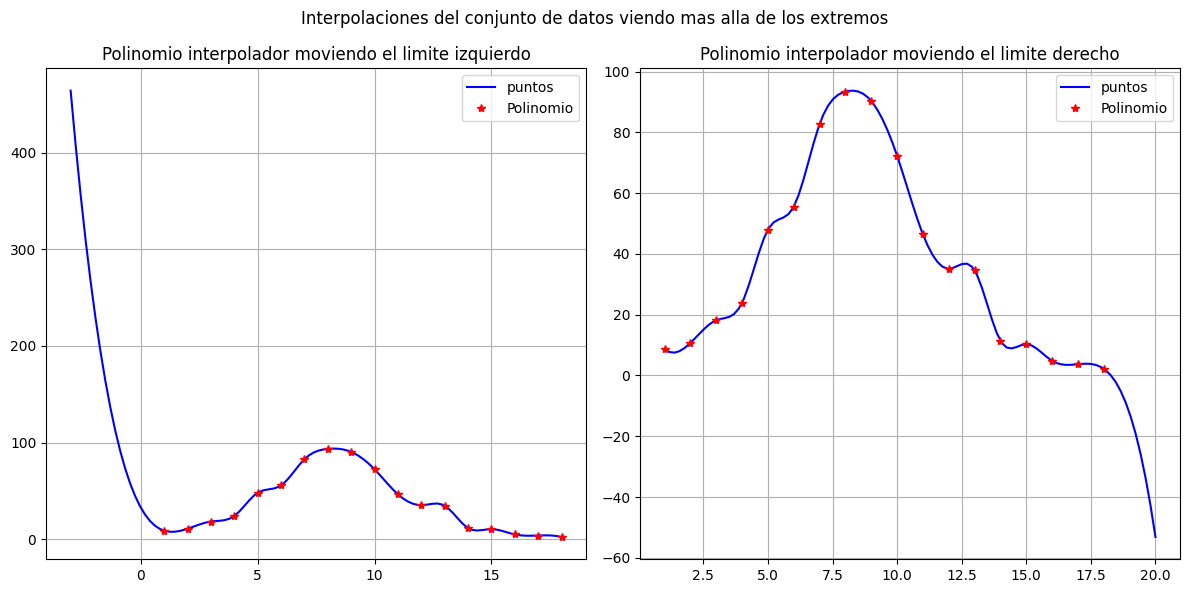

In [31]:
x = np.linspace(-3, 18, 100)
y = f(x)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle("Interpolaciones del conjunto de datos viendo mas alla de los extremos")


ax1.plot(x, y, "b-", label="puntos")
ax1.plot(hours[1:], Change_hour, "r*", label="Polinomio")
ax1.set_title("Polinomio interpolador moviendo el limite izquierdo")
ax1.grid()
ax1.legend()

x = np.linspace(1, 20, 100)
y = f(x)

ax2.plot(x, y, "b-", label="puntos")
ax2.plot(hours[1:], Change_hour, "r*", label="Polinomio")
ax2.set_title("Polinomio interpolador moviendo el limite derecho")
ax2.grid()
ax2.legend()

plt.tight_layout()

En ambos gráficos, se puede apreciar que la función del polinomio interpolador en los extremos tiende a crecer de manera muy rápida en comparación con los puntos interpolados. Probablemente esto se deba a la naturaleza del conjunto de datos y a que las condiciones de frontera estándar de la función implementada para el spline cúbico en Python no representan la realidad.

Por un lado, en el gráfico de la izquierda, aunque la función toma valores muy positivos, indicando una gran variación de levadura entre un tiempo y otro, hablar de tiempos negativos no tiene mucho sentido en el problema, ya que no se desea observar el pasado de la levadura. Por lo tanto, este comportamiento no es relevante.

Por otro lado, en el gráfico de la derecha, se observa un comportamiento más preocupante, especialmente al responder a la pregunta general del problema (ver la cantidad de biomasa al pasar 25 horas). Esto se debe a que los cambios entre un período y otro ya no son valores positivos, sino más bien negativos. Según el polinomio interpolado, después de las 18 horas, la población no parece alcanzar un punto de concentración máxima donde la variación es casi imperceptible, sino que muestra un decrecimiento de la población que no parece reflejar el comportamiento real de esta dinámica poblacional. Por lo tanto, se sugiere ajustar la condición de frontera del límite derecho para que tienda a un valor de 0.

#### Variación de la Condición de Frontera Derecha

Con el objetivo de cambiar la condición de frontera derecha, se decidió utilizar una función por partes. La primera parte es un polinomio interpolador del conjunto de datos, y la segunda parte es una función exponencial que tiende a 0 a partir del último valor del conjunto de datos.

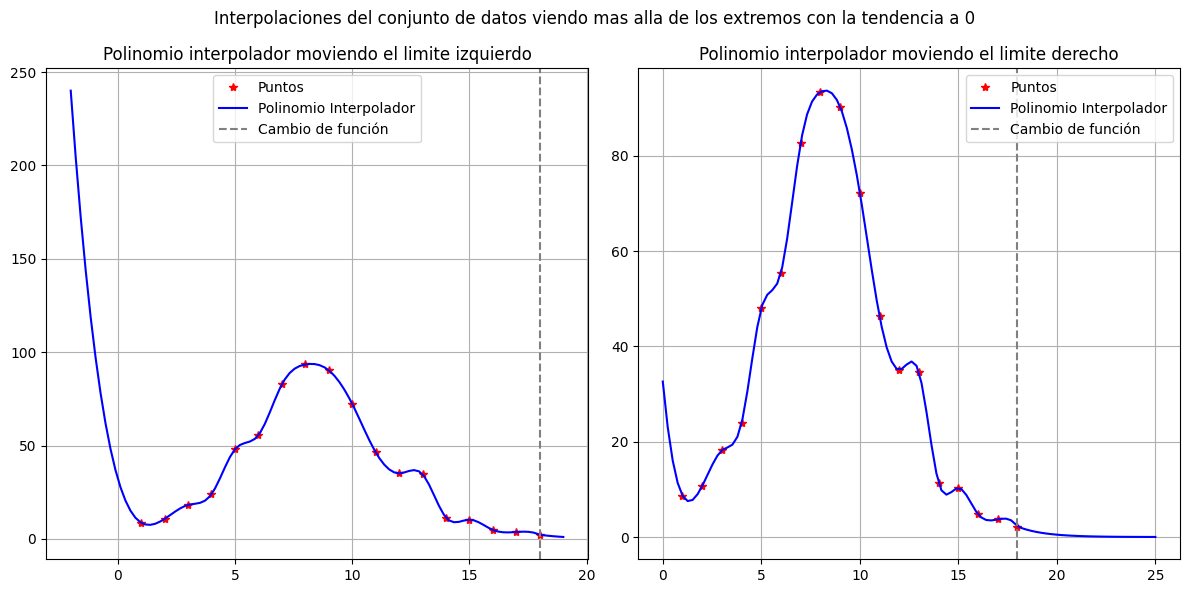

In [32]:
def exponential_decay(x, x_last, y_last, decay_rate=0.5):
  return y_last * np.exp(-decay_rate * (x - x_last))

def g(t):
    return np.piecewise(t,
                        [t <= hours[-1], t > hours[-1]],
                        [lambda t: f(t), lambda t: exponential_decay(t, hours[-1], Change_hour[-1], decay_rate=0.75)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle("Interpolaciones del conjunto de datos viendo mas alla de los extremos con la tendencia a 0")

x = np.linspace(-2, 19, 100)
y = g(x)
ax1.plot(hours[1:], Change_hour, "r*", label="Puntos")
ax1.plot(x, y, "b-", label="Polinomio Interpolador")
ax1.axvline(hours[-1], color='gray', linestyle='--', linewidth=1.5, label='Cambio de función')
ax1.set_title("Polinomio interpolador moviendo el limite izquierdo")
ax1.grid()
ax1.legend()

x = np.linspace(0, 25, 100)
y = g(x)
ax2.plot(hours[1:], Change_hour, "r*", label="Puntos")
ax2.plot(x, y, "b-", label="Polinomio Interpolador")
ax2.axvline(hours[-1], color='gray', linestyle='--', linewidth=1.5, label='Cambio de función')
ax2.set_title("Polinomio interpolador moviendo el limite derecho")
ax2.grid()
ax2.legend()
plt.tight_layout()

Al igual que con el polinomio anterior, en la frontera izquierda seguimos observando un comportamiento en el que, de un período a otro, la levadura presenta una gran variación. No obstante, dado que no deseamos considerar el pasado de la levadura, este comportamiento no es relevante. Por otro lado, en la frontera derecha, a partir del punto de quiebre, se aprecia una tendencia hacia cero. De esta manera, adaptamos la función al comportamiento de los datos.

### Método numérico de aproximación de EDOs

Como siguiente paso, se procederá a utilizar el método de Runge-Kutta sobre el primer y segundo polinomio interpolador, analizando sus comportamientos en relación con el conjunto de datos.

Para t=25 la cantidad de población usando el metodo de runge-kutta sobre el primer polinomio interpolador es: -1489.3888674265675


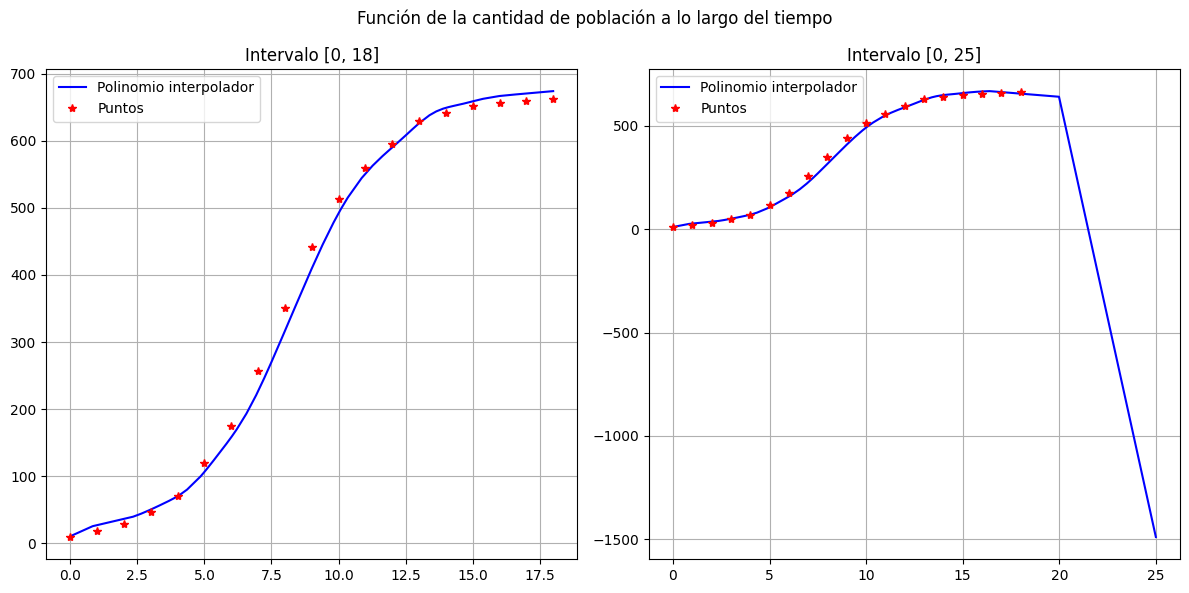

In [33]:
my_function = lambda t, y: f(t)
# Condiciones iniciales y tiempo de integración
y0 = yeast_biomass[0] # Condición inicial y(0)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle("Función de la cantidad de población a lo largo del tiempo")
sol = None
for i in range(2):
  t = None
  if i == 0: t = 18
  else: t = 25
  t_span = (0, t)   # Tiempo inicial y final

# Resolver la ecuación diferencial usando RK4
  sol = solve_ivp(my_function, t_span, [y0], rtol=1e-8, atol=1e-8)
  axt = ax[i]

  axt.plot(sol.t, sol.y[0], "-b", label="Polinomio interpolador")
  axt.plot(hours, yeast_biomass, "*r", label="Puntos")
  axt.set_title(f"Intervalo [0, {t}]")
  axt.legend()
  axt.grid()


plt.tight_layout()

print(f"Para t={25} la cantidad de población usando el metodo de runge-kutta sobre el primer polinomio interpolador es: {sol.y[0][-1]}")


Para el primer polinomio interpolador, se puede observar en las gráficas que, incluso en un tiempo cercano a los datos, como el período 20, la población comienza a decrecer, a pesar de que previamente no se mostraba ningún indicio de ello. Además, en el tiempo $t=25$, la cantidad predicha por el modelo indica que la población decrece a -1489.39. Esto sugiere que, cuando la población parece haber alcanzado el tope de su crecimiento, comienza a disminuir de inmediato.

#### Polinomio Actualizado

Para t=25 la cantidad de población usando el metodo de runge-kutta sobre el segundo polinomio interpolador es: 676.7885693166469


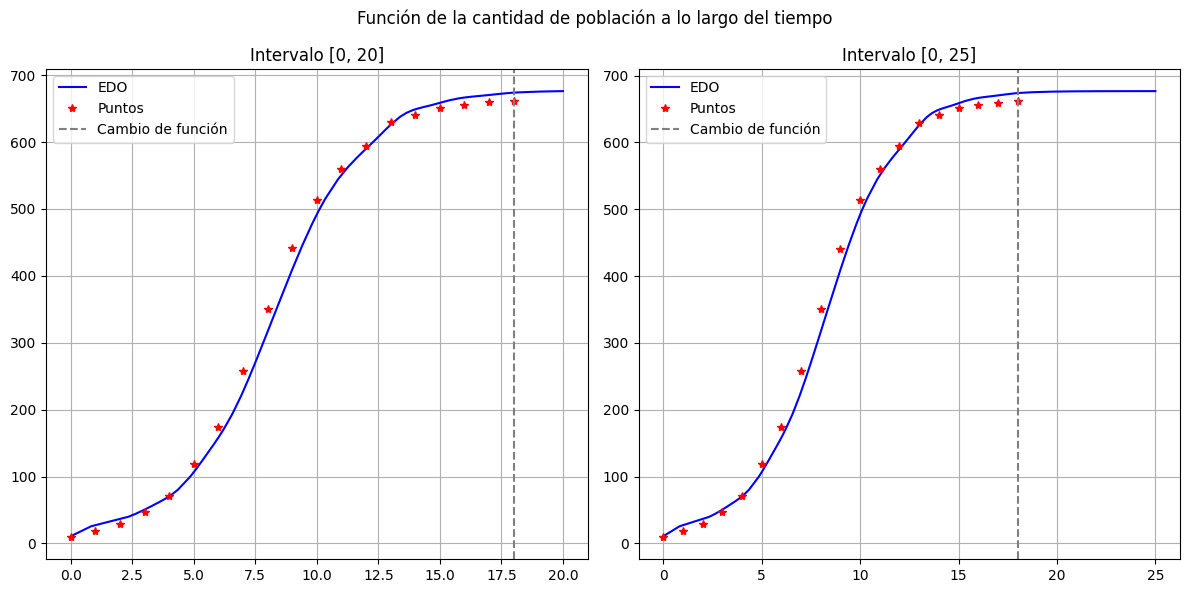

In [34]:
my_function = lambda t, y: g(t)

y0 = yeast_biomass[0] # Condición inicial y(0)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle("Función de la cantidad de población a lo largo del tiempo")
sol = None
for i in range(2):
  t = None
  if i == 0: t = 20
  else: t = 25
  t_span = (0, t)   # Tiempo inicial y final

# Resolver la ecuación diferencial usando RK4
  sol = solve_ivp(my_function, t_span, [y0], rtol=1e-8, atol=1e-8)
  axt = ax[i]

  axt.plot(sol.t, sol.y[0], "-b", label="EDO")
  axt.plot(hours, yeast_biomass, "*r", label="Puntos")
  axt.axvline(hours[-1], color='gray', linestyle='--', linewidth=1.5, label='Cambio de función')
  axt.grid()
  axt.legend()
  axt.set_title(f"Intervalo [0, {t}]")


plt.tight_layout()

print(f"Para t={25} la cantidad de población usando el metodo de runge-kutta sobre el segundo polinomio interpolador es: {sol.y[0][-1]}")

Para el segundo polinomio, se aprecia una tendencia hacia un valor de crecimiento máximo. A diferencia de la aproximación anterior, en la que la levadura comienza a decrecer y, en pocos períodos, disminuye por debajo de 0, en este modelo la aproximación para $t=25$ es de 676.788.

## Segundo Modelo: Crecimiento Logístico Discreto

Las imágenes son tomadas de las diapositivas de clase: Amador, A. Modelación con sistemas discretos. Modelización y Simulación I, PUJ Cali. Cali, Colombia.

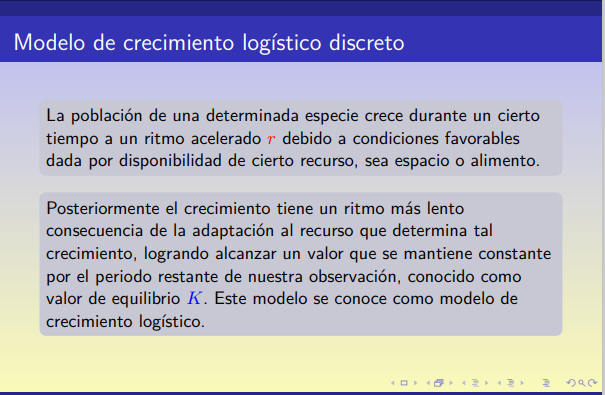

### Fórmula del modelo logístico discreto

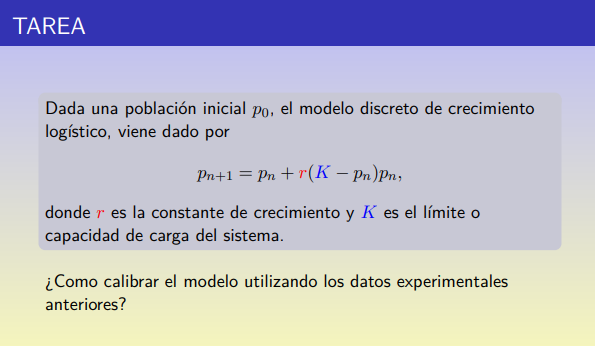



### Solución Lineal

#### Linealización

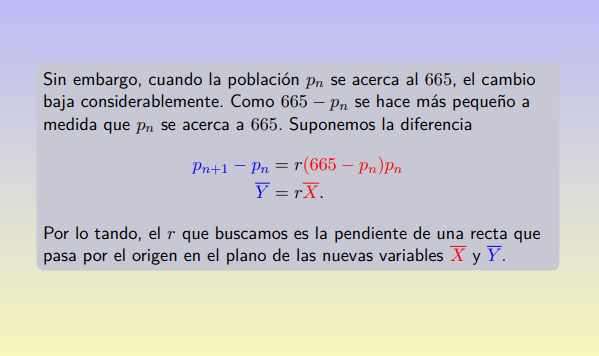

In [35]:
Y = Change_hour
n = len(Change_hour)
X = np.array([(665-yeast_biomass[i+1])*yeast_biomass[i+1] for i in range(n)])

#### Mínimos Cuadrados

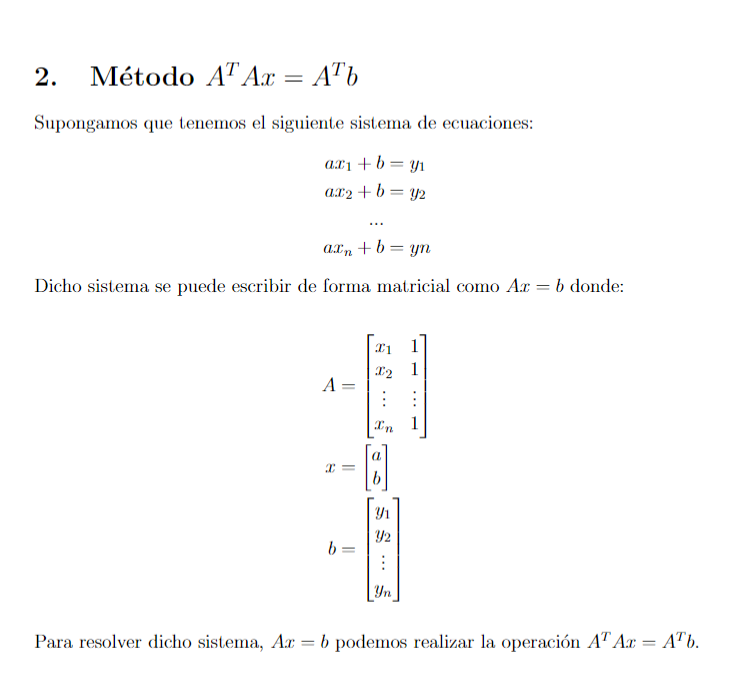

Sacado de una tarea del curso de Álgebra Lineal Computacional: Salazar, G. & Sánchez, L. Prueba de Mínimos Cuadrados.

Cabe destacar que este sistema de ecuaciones no solo puede ser utilizado para ecuaciones lineales, sino también para otros tipos de polinomios.

In [36]:
### Codigo de minimos cuadrados lineales de n variables de rango completo
def minimos_cuadrados(A, b):
  AT = np.transpose(A)
  ATA = np.dot(AT, A)
  ATb = np.dot(AT,b)
  P, L, U = la.lu(ATA)
  y = la.solve_triangular(L, np.dot(P, ATb), lower=True)
  x = la.solve_triangular(U, y, lower=False)
  return x

In [37]:
#Calculo del r por minimos cuadrados
A = np.array([[X[i]] for i in range(n)])
c = minimos_cuadrados(A, Y)

r = c[0]
K = 665

#Creacion de la recta de minimos cuadrados
f = lambda x: c[0]*x
xx = np.array([min(X)-1, max(X)+1])

#Estimación de la cantidad de levadura y variación
p0 = [yeast_biomass[0]]
p_change = []
for _ in range(1, len(yeast_biomass)):
  p_change.append(r*(K-p0[-1])*p0[-1])
  p0.append(p0[-1]+p_change[-1])

#### Resultados

Para t=25 la cantidad de población usando el modelo logístico discreto es de 664.9937568229195
El valor para la convergencia del punto fijo K es de: 0.5401482065172409


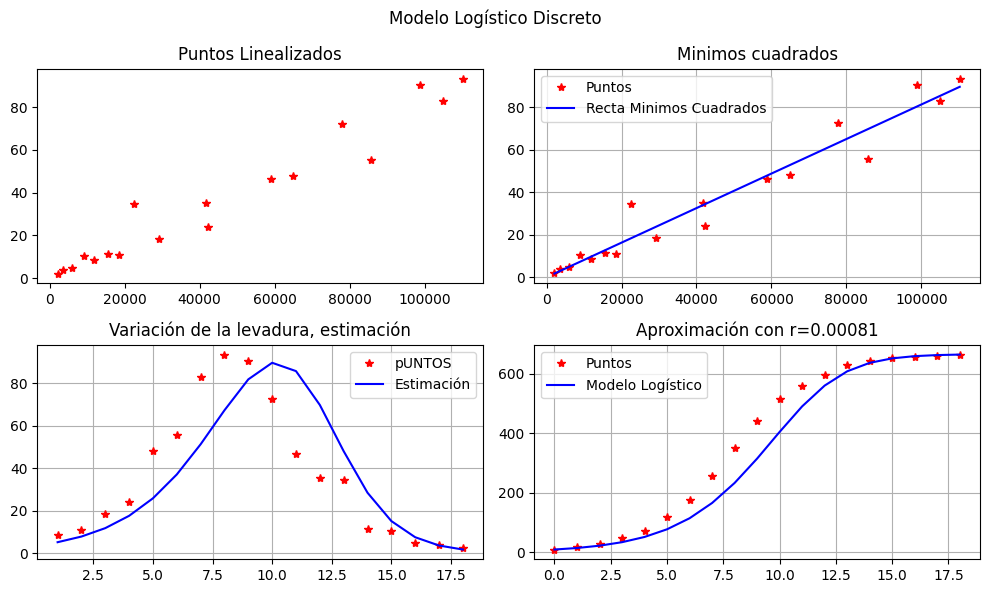

In [38]:
#Graficos
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

fig.suptitle("Modelo Logístico Discreto")

ax1, ax2, ax3, ax4 = ax[0][0], ax[0][1], ax[1][0], ax[1][1]

#Grafico 1, puntos linealizados
ax1.plot(X, Y, "r*")
ax1.grid()
ax1.grid()
ax1.set_title("Puntos Linealizados")

#Grafico 2, recta linealizado con el parametro r estimado
ax2.plot(X, Y, "r*", label="Puntos")
ax2.plot(xx, f(xx), "b-", label="Recta Minimos Cuadrados")
ax2.set_title("Minimos cuadrados")
ax2.grid()
ax2.legend()

#Grafico 3, estimación de las variazaciones con el parametro r
ax3.plot(hours[1:], Change_hour, "*r", label="pUNTOS")
ax3.plot(hours[1:], p_change, "b-", label="Estimación")
ax3.set_title("Variación de la levadura, estimación")
ax3.legend()
ax3.grid()

#Grafico 4, estimación de la cantidad con el parametro r
ax4.plot(hours, yeast_biomass, "*r", label="Puntos")
ax4.plot(hours, p0, "b-", label="Modelo Logístico")
ax4.set_title(f"Aproximación con r={r:.5f}")
ax4.grid()
ax4.legend()

plt.tight_layout()

while len(p0) <= 25:
  p0.append(p0[-1]+r*(K-p0[-1])*p0[-1])


print(f"Para t={25} la cantidad de población usando el modelo logístico discreto es de {p0[-1]}")
print(f"El valor para la convergencia del punto fijo K es de: {r*K}")

Como se puede apreciar en los gráficos, el modelo puede ser linealizado para estimar parámetros utilizando el método de mínimos cuadrados. En este caso, se estimó el parámetro $r$, que es la pendiente de una recta con la condición de pasar por el origen. Por ello, se utilizaron como sistemas de ecuaciones todas las rectas de la forma $Y_i = rX_i$.

El resultado del método arrojó que $r \approx 0.00081$, ofreciendo un modelo que se adapta de cierta manera a los datos. Sabiendo esto, la respuesta a la pregunta general de cuál es la población de levadura en el período $t = 25$ es de 664.99.

### Solución Cuadrática

Dado un conjunto de datos de las variaciones de la forma $P(x) = ax^2 + bx + c$, se desea utilizar el método de mínimos cuadrados para hallar los parámetros que minimicen el error sobre el conjunto de datos.

Para estos modelos, se crearán dos versiones distintas: una tomando el límite izquierdo como parte del conjunto de datos y otra tomando el límite derecho, para observar las variaciones.

In [39]:
def telarania(polinomio, x0, iter=15):
  mini = 2**32
  maxi = -2**32

  lineal = lambda x: x
  # x0 = -500
  y0 = polinomio(x0)
  for _ in range(iter):
    x1 = y0
    mini = x0 if x0 < mini else mini
    maxi = x0 if x0 > maxi else maxi
    plt.plot([x0, x1], [y0, x1], "k--*")
    x0 = x1
    y0 = polinomio(x0)
    plt.plot([x0, x0], [x0, y0], "k--")
    mini = x0 if x0 < mini else mini
    maxi = x0 if x0 > maxi else maxi

  xx = np.linspace(mini-5, maxi+5, 100)
  plt.plot(xx, lineal(xx), "r", label="y=x")
  plt.plot(xx, polinomio(xx),"b", label="función iterativa")
  plt.grid()
  plt.legend()
  plt.show()

#### Modelo tomando el límite izquierdo

In [40]:
A = np.array([[yeast_biomass[i]**2, yeast_biomass[i], 1] for i in range(0, len(hours)-1)])
mc = minimos_cuadrados(A, Change_hour)

a, b, c = mc
print(mc)
f = lambda x: a*(x**2)+ b*x + c
xx = np.linspace(0, yeast_biomass[-1])
yy = f(xx)

p0 = [yeast_biomass[0]]
for _ in range(1, len(yeast_biomass)):
  p0.append(p0[-1]+ a*(p0[-1]**2)+b*p0[-1]+c)

[-8.01975671e-04  5.16054679e-01  6.41123361e+00]


Para t=25 la cantidad de población usando el modelo cuadratico discreto es de 655.6700172638127


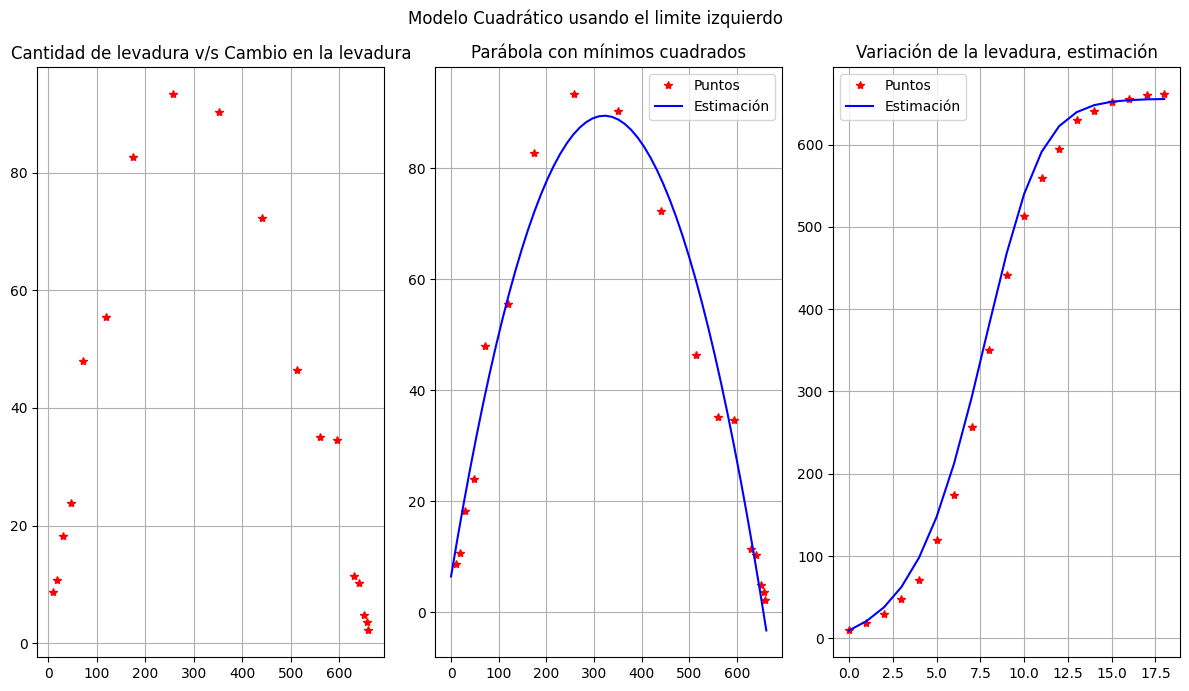

In [41]:
#Graficos
fig, ax = plt.subplots(1, 3, figsize=(12, 7))

fig.suptitle("Modelo Cuadrático usando el limite izquierdo")

ax1, ax2, ax3 = ax[0], ax[1], ax[2]

#Grafico 1, puntos cantidad de levadura vs cambio
ax1.plot(yeast_biomass[:-1], Change_hour, "r*",)
ax1.grid()
ax1.set_title("Cantidad de levadura v/s Cambio en la levadura")

#Grafico 2, recta linealizado con el parametro r estimado
ax2.plot(yeast_biomass[:-1], Change_hour, "r*", label = "Puntos")
ax2.plot(xx, yy, "-b", label = "Estimación")
ax2.grid()
ax2.set_title("Parábola con mínimos cuadrados")
ax2.legend()

#Grafico 3, estimación de las variazaciones con el parametro r
ax3.plot(hours, yeast_biomass, "*r", label="Puntos")
ax3.plot(hours, p0, "b-", label="Estimación")
ax3.set_title("Variación de la levadura, estimación")
ax3.legend()
ax3.grid()

plt.tight_layout()

while len(p0) <= 25:
  p0.append(p0[-1]+ a*(p0[-1]**2)+b*p0[-1]+c)


print(f"Para t={25} la cantidad de población usando el modelo cuadratico discreto es de {p0[-1]}")

Usando mínimos cuadrados sobre los polinomios generados tomando el límite izquierdo, se obtiene un modelo que aproxima mejor los datos que el modelo basado en la linealización. En este caso, se obtiene un valor de 655.67 para $t = 25$.

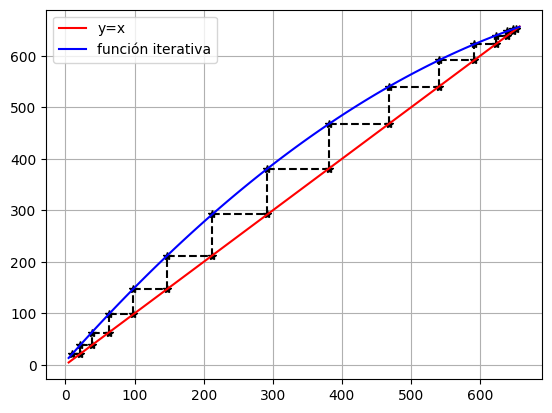

In [42]:
telarania(lambda x: x + a*(x**2) + b*x + c, yeast_biomass[0])

Para este sistema dinámico, tenemos un punto fijo atractor, por lo que podemos observar una estabilidad en la capacidad de carga del modelo.

#### Modelo tomando el límite derecho

In [43]:
A = np.array([[yeast_biomass[i]**2, yeast_biomass[i], 1] for i in range(1, len(hours))])
mc = minimos_cuadrados(A, Change_hour)

a, b, c = mc
print(mc)
f = lambda x: a*(x**2)+ b*x + c
xx = np.linspace(0, yeast_biomass[-1])
yy = f(xx)

p0 = [yeast_biomass[0]]
for _ in range(1, len(yeast_biomass)-8):
  p0.append(p0[-1]+ a*(p0[-1]**2)+b*p0[-1]+c)

[-8.44212195e-04  5.78650319e-01 -8.22568875e+00]


Para t=25 la cantidad de población usando el modelo cuadratico discreto es de -inf


C:\Users\guidi\AppData\Local\Temp\ipykernel_27928\820146407.py:30: RuntimeWarning: overflow encountered in scalar power
  p0.append(p0[-1]+ a*(p0[-1]**2)+b*p0[-1]+c)


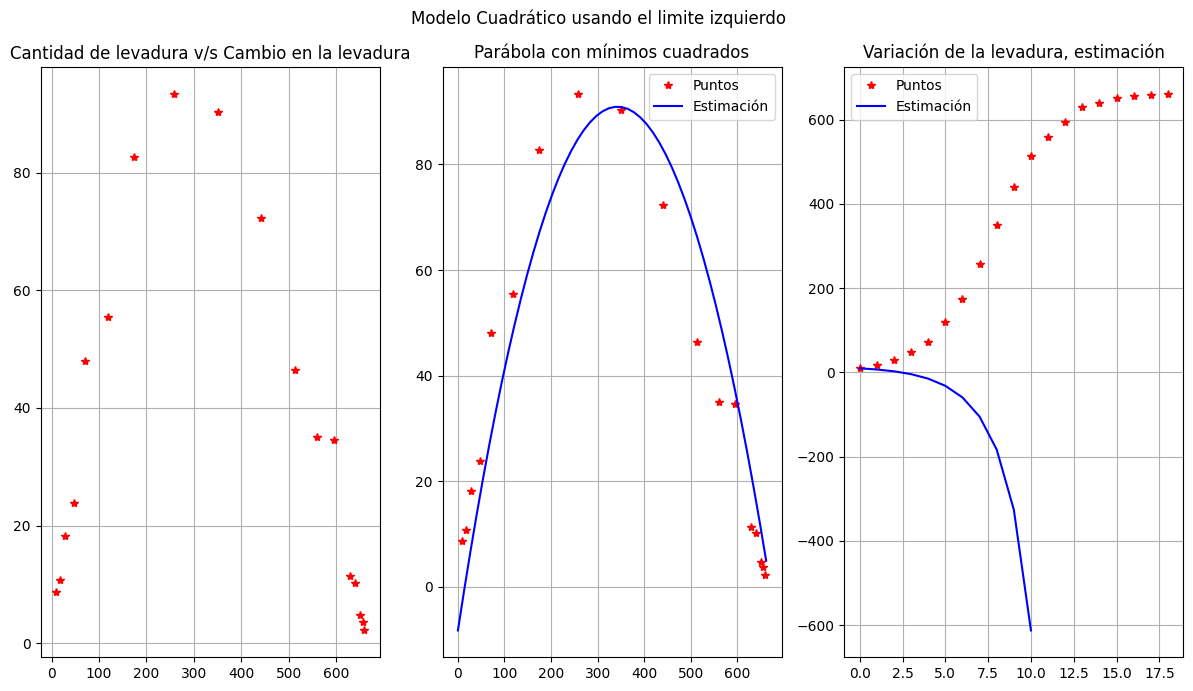

In [44]:
#Graficos
fig, ax = plt.subplots(1, 3, figsize=(12, 7))

fig.suptitle("Modelo Cuadrático usando el limite izquierdo")

ax1, ax2, ax3 = ax[0], ax[1], ax[2]

#Grafico 1, puntos cantidad de levadura vs cambio
ax1.plot(yeast_biomass[:-1], Change_hour, "r*",)
ax1.grid()
ax1.set_title("Cantidad de levadura v/s Cambio en la levadura")

#Grafico 2, recta linealizado con el parametro r estimado
ax2.plot(yeast_biomass[:-1], Change_hour, "r*", label = "Puntos")
ax2.plot(xx, yy, "-b", label = "Estimación")
ax2.grid()
ax2.set_title("Parábola con mínimos cuadrados")
ax2.legend()

#Grafico 3, estimación de las variazaciones con el parametro r
ax3.plot(hours, yeast_biomass, "*r", label="Puntos")
ax3.plot(hours[:len(p0)], p0, "b-", label="Estimación")
ax3.set_title("Variación de la levadura, estimación")
ax3.legend()
ax3.grid()

plt.tight_layout()

while len(p0) <= 25:
  p0.append(p0[-1]+ a*(p0[-1]**2)+b*p0[-1]+c)


print(f"Para t={25} la cantidad de población usando el modelo cuadratico discreto es de {p0[-1]}")

Usando mínimos cuadrados sobre los polinomios generados con el límite derecho, se obtiene un modelo que no aproxima los datos, sino que diverge hacia una solución que tiende al infinito negativo.

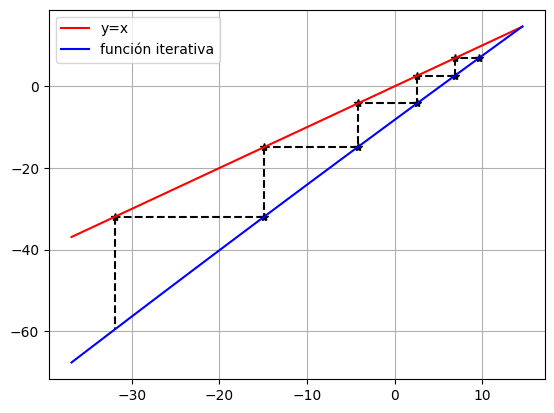

In [45]:
telarania(lambda x: x + a*(x**2) + b*x + c, yeast_biomass[0], iter=5)

Para este sistema dinámico, tenemos un punto fijo repulsor negativo, lo que implica que el modelo predice una cantidad negativa de población, lo cual no tiene sentido. Debido a esta naturaleza, aunque la parábola se adapta bien a los resultados, la gráfica poblacional tiende a irse al infinito negativo, ya que la población, en lugar de crecer, disminuye. Esto hace que no haya concordancia con los datos. No obstante, surge la pregunta: ¿qué pasaría si obligamos a la parábola a pasar por el origen?

#### Modelo tomando el límite derecho igualando $c = 0$

In [46]:
A = np.array([[yeast_biomass[i]**2, yeast_biomass[i]] for i in range(1, len(hours))])
mc = minimos_cuadrados(A, Change_hour)

a, b = mc
print(mc)
c = 0
f = lambda x: a*(x**2)+ b*x + c
xx = np.linspace(0, yeast_biomass[-1])
yy = f(xx)

p0 = [yeast_biomass[0]]
for _ in range(1, len(yeast_biomass)):
  p0.append(p0[-1]+ a*(p0[-1]**2)+b*p0[-1]+c)

[-0.00078172  0.526538  ]


Para t=25 la cantidad de población usando el modelo cuadratico discreto es de 673.5549276550804


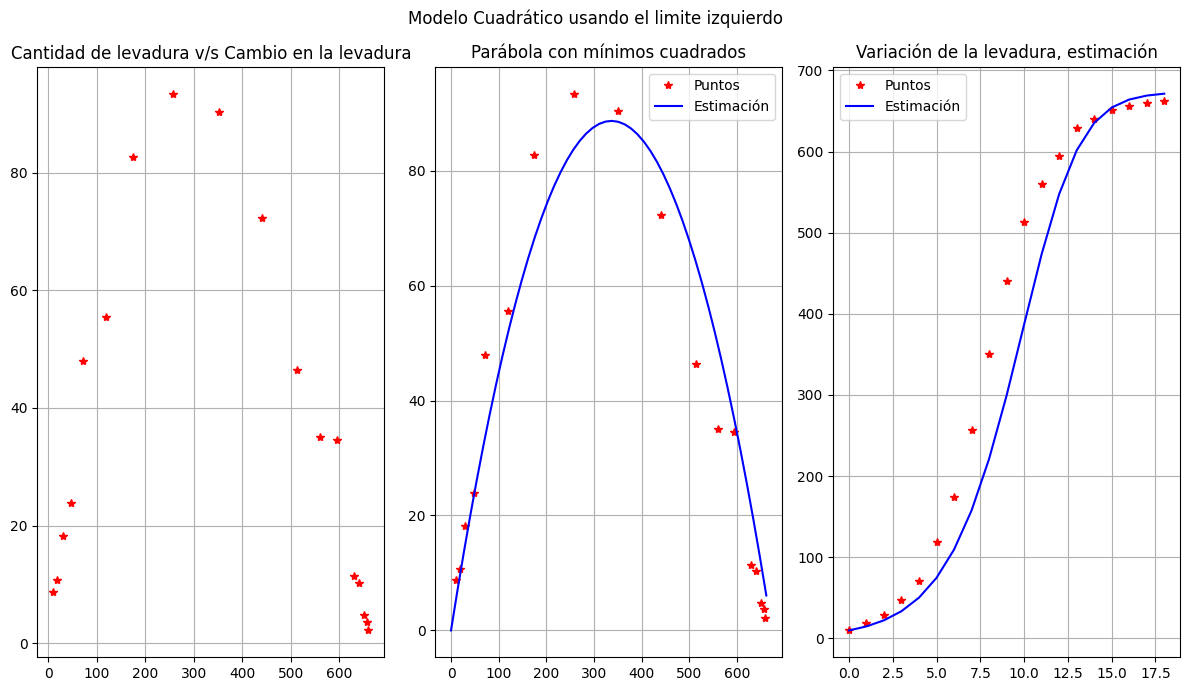

In [47]:
#Graficos
fig, ax = plt.subplots(1, 3, figsize=(12, 7))

fig.suptitle("Modelo Cuadrático usando el limite izquierdo")

ax1, ax2, ax3 = ax[0], ax[1], ax[2]

#Grafico 1, puntos cantidad de levadura vs cambio
ax1.plot(yeast_biomass[:-1], Change_hour, "r*",)
ax1.grid()
ax1.set_title("Cantidad de levadura v/s Cambio en la levadura")

#Grafico 2, recta linealizado con el parametro r estimado
ax2.plot(yeast_biomass[:-1], Change_hour, "r*", label = "Puntos")
ax2.plot(xx, yy, "-b", label = "Estimación")
ax2.grid()
ax2.set_title("Parábola con mínimos cuadrados")
ax2.legend()

#Grafico 3, estimación de las variazaciones con el parametro r
ax3.plot(hours, yeast_biomass, "*r", label="Puntos")
ax3.plot(hours, p0, "b-", label="Estimación")
ax3.set_title("Variación de la levadura, estimación")
ax3.legend()
ax3.grid()

plt.tight_layout()

n = 25
while len(p0) <= n:
  p0.append(p0[-1]+ a*(p0[-1]**2)+b*p0[-1]+c)

print(f"Para t={25} la cantidad de población usando el modelo cuadratico discreto es de {p0[-1]}")

Usando mínimos cuadrados sobre los polinomios generados con el límite derecho, pero obligando a la parábola a pasar por el origen, se soluciona el problema de que la población decaiga a lo largo del tiempo. Esto da como resultado, para la cantidad de población en el tiempo $t = 25$, un valor de 673.55.

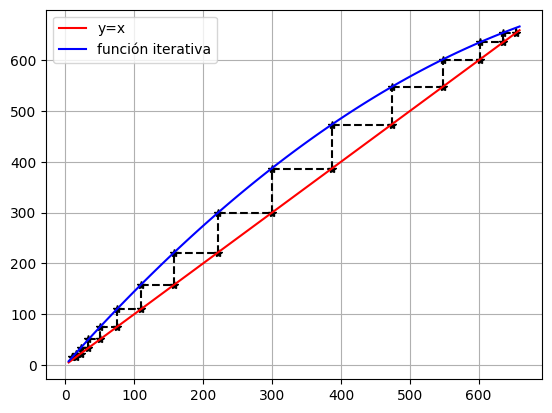

In [48]:
telarania(lambda x: x + a*(x**2) + b*x + c, yeast_biomass[0])

Para este sistema dinámico, el punto fijo atractivo vuelve a estar en la capacidad de carga del sistema, por lo que la población se estabiliza nuevamente en un valor.

## Tercer Modelo: Modelo Logístico Adaptado a un Parámetro

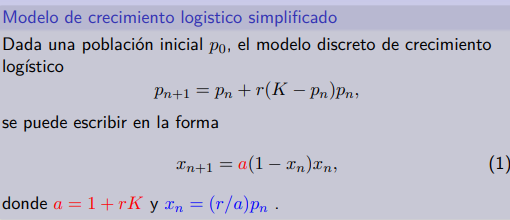



In [49]:
a = 1+r*K

#Estimación de la cantidad de levadura y variación
p0 = [yeast_biomass[0]]
x0 = [(r/a)*p0[0]]
for _ in range(1, len(yeast_biomass)):
  x0.append(a*(1-x0[-1])*x0[-1])
  p0.append(x0[-1]*(a/r))


Para t=25 la cantidad de población usando el modelo logístico discreto es de 664.9864238272838
El valor para de a es: 1.540148206517241


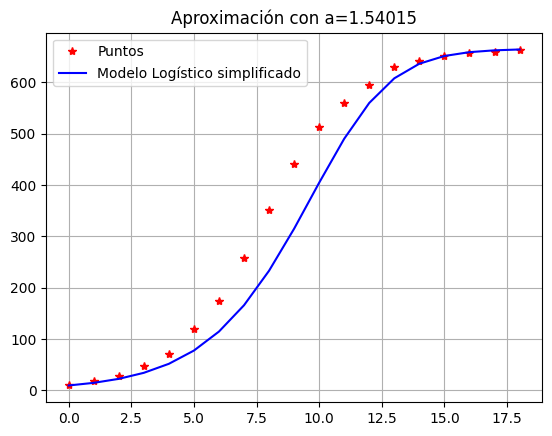

In [50]:
#Grafico 1, puntos cantidad de horas vs levadura
plt.plot(hours, yeast_biomass, "*r", label="Puntos")
plt.plot(hours, p0, "b-", label="Modelo Logístico simplificado")
plt.grid()
plt.title(f"Aproximación con a={a:.5f}")
plt.legend()

plt.show

while len(p0) < 25:
  x0.append(a*(1-x0[-1])*x0[-1])
  p0.append(x0[-1]*(a/r))


print(f"Para t={25} la cantidad de población usando el modelo logístico discreto es de {p0[-1]}")
print(f"El valor para de a es: {a}")

## Simulación del Comportamiento de las Poblaciones al Aumentar el Parámetro $a$

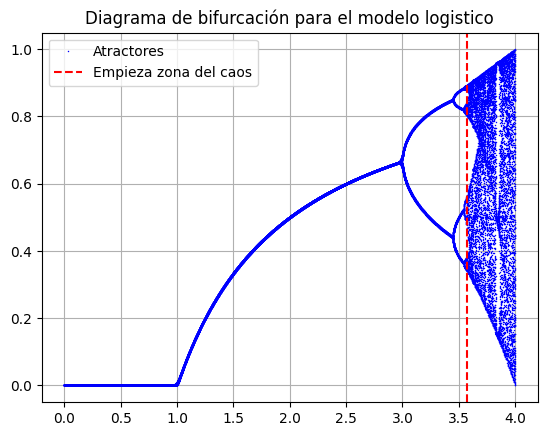

In [51]:
from random import randint

def logistic(a, x0, n):
  ans = x0
  for _ in range(n):
    ans = a*(1-ans)*ans
  return ans

def bifurcacion(x0):
  valor_a = np.linspace(0, 4, 100000)
  y = []
  N = 300
  for a in valor_a:
    n = randint(100, N)
    y.append(logistic(a, x0, n))
  plt.plot(valor_a, y, "b*", markersize=0.5, label="Atractores")
  plt.axvline(3.57, color='red', linestyle='--', linewidth=1.5, label='Empieza zona del caos')
  plt.title("Diagrama de bifurcación para el modelo logistico")
  plt.grid()
  plt.legend()
  plt.show()

bifurcacion(0.5)